# Walkthrough for Jupyter

In this notebook we'll walk through how to get rolling with Notebooks.

Important to note that **Jupyter Notebook file ≠ a Python file.**

## 1. Generating the data

For this demo, lets generate two distinct clusters of (x,y,z) coordinate data.

In [ ]:
# BAD CODE, DON"T DO THIS:
import numpy as np
total_numbers = 200
mean1, std_dev1 = 0, 4
cluster1 = np.random.normal(mean1, std_dev1, size=(total_numbers,3))
mean2, std_dev2 = 10, 5
cluster2 = np.random.normal(mean2, std_dev2, size=(total_numbers,3))

In [1]:
# Preamble:
%matplotlib inline
import numpy as np
import numpy.random as rnd
import pickle as pkl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import tensorflow as tf
from sklearn import model_selection
from IPython.display import clear_output

py.offline.init_notebook_mode(connected=True)

# Global Vars:
total_numbers = 200
number_of_clusters = 2
mean, std_dev = [0, 10], [4, 5]

# Set a seed:
rnd.seed(42) 

# Logging levels:
#tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
def generate_data():
    "This function generates <number_of_clusters> set of x,y,z points"
    global data_points
    
    data_points = []
    
    for group in range(number_of_clusters):
        random_points = rnd.normal(mean[group], std_dev[group], size=(total_numbers,3))
        data_points.append(random_points)

In [ ]:
# generate_data()

Now that we have data generated in `data_points`, we don't want to re-generate it everytime. It takes time to compute, and when randomness is at play, we might get different numbers every time. Getting different numbers everytime means we won't know if things have changed for the better. 

**Use seeds!** They are critical in being able to have reproductivity in your code. All variables which deal with randomness and machine learning have a seed option that can be set.

When data has been generated in python, it doesn't need to be re-generated everytime. The `pickle` package is your best friend!

In [7]:
def save_pickle_file(name, data):
    "Save out the data as a pickle file"
    with open("output/{}.pkl".format(name), "wb") as pickle_file:
        pkl.dump(data, pickle_file)

def load_pickle_file(name):
    "Get the value from the pickle file and set it as the variable value"
    with open("output/{}.pkl".format(name), "rb") as pickle_file:        
        globals()[name] = np.array(pkl.load(pickle_file))

In [8]:
#save_pickle_file("data_points", data_points)
load_pickle_file("data_points")

## 2. Visualize what we have

Visualizations are one of the key features of Jupyter Notebooks. 

I personally like jot down the type of visualization I am aiming for on paper.

![drawn graph](images/drawing.jpg "Drawing")

In [9]:
# %load snippets/3dplot.py

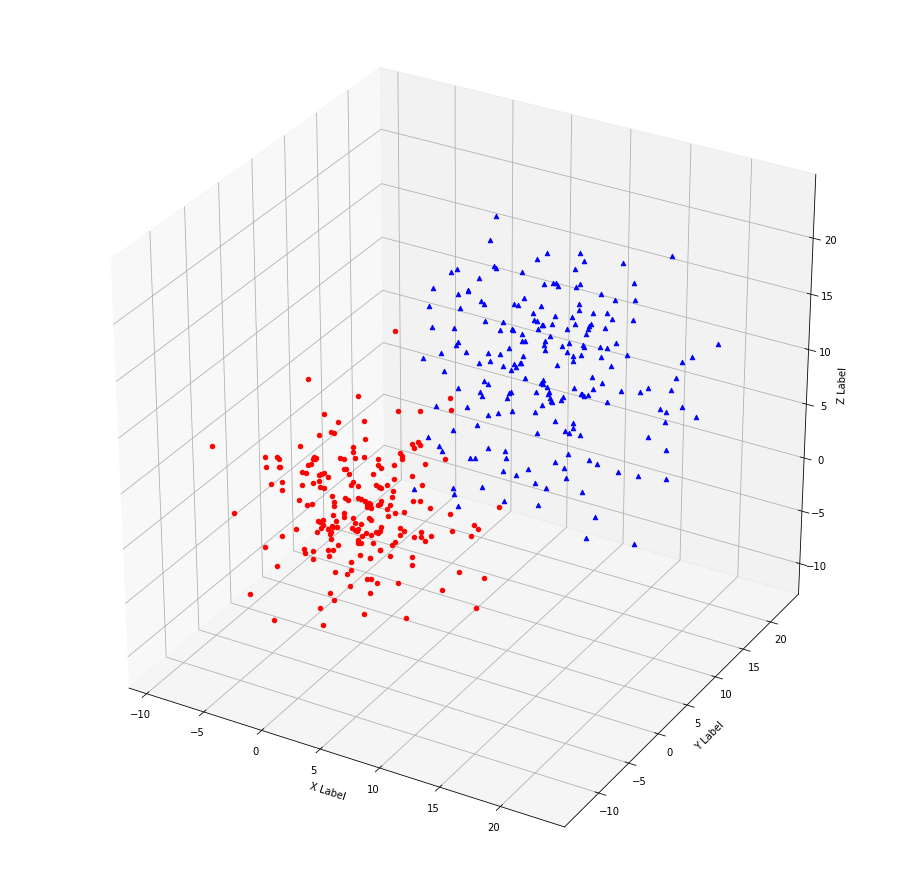

In [10]:
# plot_3d()

Cool! We got the visualization that we wanted, and we save it out everytime it is rendered. Saving the image out and putting it on version control (`git`) is a great way to track the graphics.

### Interactive Visualizations 

Interactive visualizations are not much harder than the interactive one. For our particular case, we will be using [Plot.ly](https://plot.ly/). The service requires you to create an account and have an API key (follow [these instructions](https://plot.ly/python/getting-started/)). 

Even though Plot.ly is a paid service, I have a little life-hack which allows you to create as many plots as you want while sticking to the free plan.

After creating an account with Plot.ly, run the following code one time:
```python
import plotly
plotly.tools.set_credentials_file(username='DemoAccount', api_key='lr1c37zw81')
```

In [13]:
# %load snippets/3d-interactive-plot.py

In [14]:
# interactive_3d_plot()

## 3. Machine Learning

Let's create a basic `tensorflow` model which is able to classify any given point as either group 1 (red group) and group 2 (blue group).

In [20]:
# %load snippets/ml.py
def deep_classifier():
    '''
    Make a basic tensorflow DNN
    '''
    # Get the data into an np array which makes things easy
    data = np.concatenate((data_points[0], data_points[1]), axis=0)
    labels = np.repeat([0, 1], 200)
    
    # Split into training and testing data:
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        data, labels, test_size=0.2, random_state=100)
    
    feature_columns = [tf.feature_column.numeric_column('x', shape=np.array(x_train).shape[1:])] 
    
    get_train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':x_train}, y=y_train, num_epochs=5, shuffle=True)
    
    get_test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':x_test}, y=y_test, num_epochs=1, shuffle=True)
    
    # Create a DNN classifier:
    classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, 
            hidden_units=[1000, 100, 10], n_classes=2, model_dir="model",
            optimizer=tf.train.ProximalAdagradOptimizer(
                learning_rate=0.0001,
                l1_regularization_strength=0.01),
                config=tf.estimator.RunConfig().replace(save_summary_steps=10))
    
    # Train the classifier:
    classifier.train(input_fn=get_train_input_fn, steps=1000)

    scores = classifier.evaluate(input_fn=get_test_input_fn)
    
    print('Accuracy (tf.estimator): {0:f}'.format(scores['accuracy']))
    
    return classifier

In [21]:
classifier = deep_classifier()

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2b62e4e107f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-3032
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3033 into model/model.ckpt.
INFO:tensorflow:loss =

Different results can be gotten by changing various parameters of the DNNClassifier (such as the `learning_rate` and `num_epochs`). Since the same directory `model/` is being used to serve TensorBoard, TensorBoard will keep track of historical models.

In [22]:
def make_prediction(points):
    "Try to predict the class of the point for our own point"
    our_point_fn = tf.estimator.inputs.numpy_input_fn(x={'x':points}, shuffle=False)

    # Make a prediction:
    prediction = classifier.predict(input_fn=our_point_fn)
    return prediction

# The points:
# points = np.array([[3, -3, 0], [15, 7, 17]]) # Answers: class 0, then class 1

for index, pred in enumerate(list(make_prediction(points))):
    print(points[index], '→' , pred['class_ids'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-3045
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 3 -3  0] → [0]
[15  7 17] → [1]


## 4. Interactivity

Most people do not know this but Jupyter has a built in feature which allows us to to easily take in user input. Here we'll take in the `x,y,z` points from the user and then make a classification based on the model prediction. Here are the [docs for interactive widgets](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html).

In [27]:
from ipywidgets import widgets
%matplotlib notebook

In [24]:
# Define the x, y, z sliders
x = widgets.FloatSlider(
    value=1.0,
    min=np.min(data_points[0][:, 0]),
    max=np.max(data_points[1][:, 0]),
    step=1.0,
    description='X:',
    continuous_update = False
)

y = widgets.FloatSlider(
    value=1.0,
    min=np.min(data_points[0][:, 1]),
    max=np.max(data_points[1][:, 1]),
    step=1.0,
    description='Y:',
    continuous_update = False
)

z = widgets.FloatSlider(
    value=1.0,
    min=np.min(data_points[0][:, 2]),
    max=np.max(data_points[1][:, 2]),
    step=1.0,
    description='Z:',
    continuous_update = False
)

button = widgets.Button(description="Predict Point")

In [25]:
box = widgets.HBox(children=[x, y, z, button])

<IPython.core.display.Javascript object>


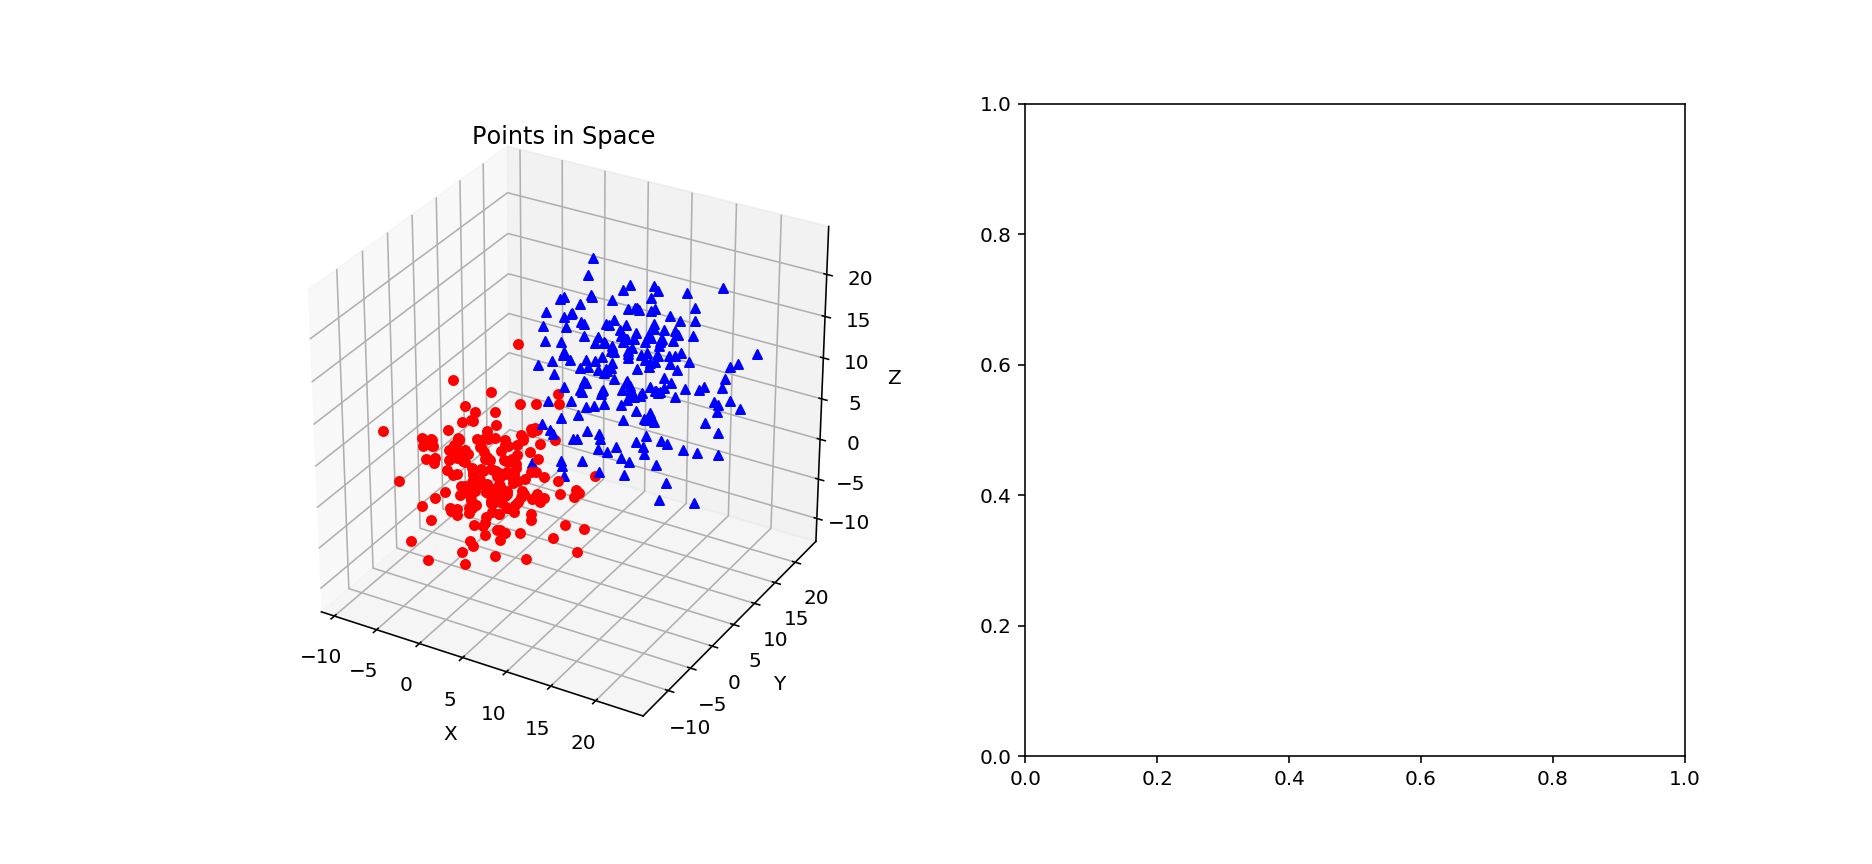

In [28]:
fig = plt.figure(figsize=(13, 6))
fig.canvas.set_window_title('Prediction Maker')
ax = fig.add_subplot(121, projection='3d')
ay = fig.add_subplot(122)
ax.set_title('Points in Space')

def create_initial_plot():
    "Create the initial plot with all the data_points"
    # Add the points: 
    i = 0
    for group in data_points:
        for point in group:
            ax.scatter(point[0], point[1], point[2], c=marks_and_colors[i][0], marker=marks_and_colors[i][1])
        i = i + 1

    # Labels:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

def button_clicked(change):
    "Ran when the button is clicked"
    global my_point
    # Remove the old point:
    try:
        my_point.remove()
    except:
        print("The green point has been added")
        
    # Plot our new point:
    my_point = ax.scatter(x.value, y.value, z.value, c="g", marker="o", s=600)
    
    # Make the prediciton:
    prediction = make_prediction(np.array([[x.value, y.value, z.value]]))
    prob = list(prediction)[0]['probabilities']
    
    # Plot the prediction:
    ay.cla()
    ay.set_title('Point Prediction')
    ay.bar([0, 1], prob, align='center', color=['red', 'blue'])
    ay.set_xticks([0, 1])
    ay.set_xticklabels(['red', 'blue'])
    
create_initial_plot()

In [ ]:
# Listen for when the button is clicked, then make the callback:
button.on_click(button_clicked)

# Display the box:
display(box)

In order to listen for just changes in specific values (without a button), use the following: `x.observe(some_function)` where `some_function` is a callback function. 

### Useful magic commands:

Magic commands are run by havinv `%` at the start of a cell. Here are some useful ones I use often:

- `%time` - Times execution of a cell.
- `%load hello_world.py` - Will load in the contents of a file into a cell
- `%store data` - Will store data to be used by other Notebooks. `%store -r data` in a different Notebook will bring in that data to be used.
- `%lsmagic` - List out all the magic commands.

To learn about any magic command, run the magic command with a `?` at the end. For instance `%time?`.

You can also run bash commands by having `!` before a bash command. For instance `!ls`.

In [ ]:
!whoami

In [ ]:
%time
print('time me')

In [ ]:
%lsmagic

In [ ]:
%%latex
$y=mx+b$

In [ ]:
%%ruby
puts 'Ruby inside Jupyter!'

In [ ]:
%%html
<h3>If you have any questions, feel free to <a href="mailto:mnkhan@ucdavis.edu">email me</a>!</h3>